In [ ]:
pip install kaggle

In [ ]:
pip install kagglehub

In [ ]:
import os
import pandas as pd

In [1]:
import pandas as pd
import os

# Define your local data path
data_path = '../data/goodbooks-10k'  # adjust path if needed

# Load all available CSV files
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
to_read = pd.read_csv(os.path.join(data_path, 'to_read.csv'))
book_tags = pd.read_csv(os.path.join(data_path, 'book_tags.csv'))
tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))

# Quick verification:
print(f"books.csv shape: {books.shape}")
print(f"ratings.csv shape: {ratings.shape}")
print(f"to_read.csv shape: {to_read.shape}")
print(f"book_tags.csv shape: {book_tags.shape}")
print(f"tags.csv shape: {tags.shape}")

# Preview few rows from each file:
print("\nBooks sample:")
print(books.head())

print("\nRatings sample:")
print(ratings.head())

print("\nTo-Read sample:")
print(to_read.head())

print("\nBook Tags sample:")
print(book_tags.head())

print("\nTags sample:")
print(tags.head())


books.csv shape: (10000, 23)
ratings.csv shape: (5976479, 3)
to_read.csv shape: (912705, 2)
book_tags.csv shape: (999912, 3)
tags.csv shape: (34252, 2)

Books sample:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee        

In [ ]:
# import pandas as pd
# import os

# # Load books.csv
# data_path = '../data/goodbooks-10k'
# books = pd.read_csv(os.path.join(data_path, 'books.csv'))

# # Total number of books
# total_books = len(books)

# # Total number of unique languages (excluding NaN)
# unique_languages = books['language_code'].nunique()

# # Number of books with missing language_code
# missing_languages = books['language_code'].isnull().sum()

# # Count number of books per language
# books_per_language = books['language_code'].value_counts()

# # Full list of languages
# languages_list = books['language_code'].dropna().unique()

# # Print summary
# print(f"Total number of books: {total_books}")
# print(f"Total unique languages: {unique_languages}")
# print(f"Number of books missing language info: {missing_languages}\n")

# print("Number of books per language:")
# print(books_per_language)

# print("\nList of languages:")
# print(languages_list)


In [4]:
import pandas as pd
import os

# Load books.csv
data_path = '../data/goodbooks-10k'
books = pd.read_csv(os.path.join(data_path, 'books.csv'))

# Drop books where publication year is missing
books = books.dropna(subset=['original_publication_year'])

# Convert year to integer for consistency
books['original_publication_year'] = books['original_publication_year'].astype(int)

# Verify
print(f"Total books after cleaning: {len(books)}")

# Save the cleaned dataframe (replacing the original file)
books.to_csv(os.path.join(data_path, 'books.csv'), index=False)


Total books after cleaning: 9979


In [7]:
import pandas as pd
import os

# Load the cleaned books.csv
data_path = '../data/goodbooks-10k'
books = pd.read_csv(os.path.join(data_path, 'books.csv'))

# Print first few rows
# print(books.head())

# Or print a random sample of 10 books
print("\nRandom sample of books:")
books.sample(10)



Random sample of books:


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
2534,2537,6406018,6406018,6594903,15,759530017,9.780760e+12,Atsushi Ohkubo,2004,ソウルイーター 1,...,34289,34473,354,532,1299,4899,8255,19488,https://images.gr-assets.com/books/1443900841m...,https://images.gr-assets.com/books/1443900841s...
1672,1675,5187,5187,3234420,18,385265700,9.780385e+12,Jane Hamilton,1988,The Book of Ruth,...,56842,57244,1139,1246,3447,15031,22252,15268,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
4740,4748,206309,206309,1138219,47,786866020,9.780787e+12,"Stephen C. Lundin, Harry Paul, John Christense...",1996,Fish! A Remarkable Way to Boost Morale and Imp...,...,19405,20340,770,466,1291,4735,6684,7164,https://images.gr-assets.com/books/1393219562m...,https://images.gr-assets.com/books/1393219562s...
1077,1080,12294652,12294652,17271423,33,803736991,9.780804e+12,Huntley Fitzpatrick,2012,My Life Next Door,...,102012,108389,8327,2477,5584,21074,37209,42045,https://images.gr-assets.com/books/1394240144m...,https://images.gr-assets.com/books/1394240144s...
8932,8950,72148,72148,865487,47,747589372,9.780748e+12,William Boyd,2006,Restless,...,9308,11228,1051,128,532,2862,5202,2504,https://images.gr-assets.com/books/1330951946m...,https://images.gr-assets.com/books/1330951946s...
8790,8808,8575295,30123413,13444179,27,NaN,NaN,Amanda Hocking,2010,Wisdom,...,12933,15399,597,235,758,3150,5321,5935,https://images.gr-assets.com/books/1282281680m...,https://images.gr-assets.com/books/1282281680s...
6235,6247,13545345,13545345,17381882,51,085707685X,9.780857e+12,Rachel Renée Russell,2012,Tales From a Not-So-Graceful Ice Princess,...,13618,15518,678,297,511,1812,3349,9549,https://images.gr-assets.com/books/1370064558m...,https://images.gr-assets.com/books/1370064558s...
3604,3608,30271,30271,2963636,34,515139750,9.780515e+12,Laurell K. Hamilton,2004,"Incubus Dreams (Anita Blake, Vampire Hunter, #12)",...,39200,41654,891,1901,4171,9739,11320,14523,https://images.gr-assets.com/books/1362831466m...,https://images.gr-assets.com/books/1362831466s...
9481,9500,13056511,13056511,14240586,46,312656289,9.780313e+12,Alexandra Adornetto,2012,Heaven,...,14520,15135,1122,778,1164,3011,3894,6288,https://images.gr-assets.com/books/1332367132m...,https://images.gr-assets.com/books/1332367132s...
1913,1916,232109,232109,2029611,63,380709244,9.780381e+12,"Beverly Cleary, Louis Darling, Tracy Dockray",1965,The Mouse and the Motorcycle,...,61754,63725,1419,952,3280,17270,21684,20539,https://images.gr-assets.com/books/1348990967m...,https://images.gr-assets.com/books/1348990967s...


In [11]:
import pandas as pd
import os

# Load data
data_path = '../data/goodbooks-10k'
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))

# Create decade column in books
books['decade'] = (books['original_publication_year'] // 10) * 10

# Merge ratings with books to attach decade
merged_df = pd.merge(ratings, books[['book_id', 'decade']], on='book_id', how='left')

# Count unique book_id per decade
unique_books_per_decade = merged_df.groupby('decade')['book_id'].nunique().reset_index(name='unique_books')

# Sort and print
unique_books_per_decade = unique_books_per_decade.sort_values('decade')
print("Unique books per decade:")
print(unique_books_per_decade)


Unique books per decade:
    decade  unique_books
0  -1750.0             1
1   -770.0             1
2   -750.0             2
3   -720.0             1
4   -560.0             1
..     ...           ...
78  1970.0           400
79  1980.0           704
80  1990.0          1360
81  2000.0          3121
82  2010.0          3067

[83 rows x 2 columns]


In [12]:
# Count total ratings per decade
ratings_per_decade = merged_df.groupby('decade')['rating'].count().reset_index(name='total_ratings')

# Sort and print
ratings_per_decade = ratings_per_decade.sort_values('decade')
print("\nTotal ratings per decade:")
print(ratings_per_decade)



Total ratings per decade:
    decade  total_ratings
0  -1750.0            730
1   -770.0            756
2   -750.0           3944
3   -720.0           6301
4   -560.0           1548
..     ...            ...
78  1970.0         244194
79  1980.0         443368
80  1990.0         847948
81  2000.0        1808808
82  2010.0        1268418

[83 rows x 2 columns]


In [13]:
# Total unique book IDs in ratings file
total_unique_books_in_ratings = ratings['book_id'].nunique()

# Total unique book IDs in books file (metadata)
total_unique_books_in_books = books['book_id'].nunique()

print(f"Unique book IDs in ratings.csv: {total_unique_books_in_ratings}")
print(f"Unique book IDs in books.csv: {total_unique_books_in_books}")


Unique book IDs in ratings.csv: 10000
Unique book IDs in books.csv: 9979


In [14]:
# Check for duplicated titles with different years
duplicates = books.groupby('title')['original_publication_year'].nunique()
multiple_year_titles = duplicates[duplicates > 1]

print(f"Number of titles with multiple publication years: {len(multiple_year_titles)}")
print(multiple_year_titles.head(10))


Number of titles with multiple publication years: 33
title
'Salem's Lot                                 2
Anatomy for the Artist                       2
Arcadia                                      2
Are You My Mother?                           2
Bambi                                        2
Between the Lines (Between the Lines, #1)    2
Invisible                                    2
Leviathan                                    2
Monster                                      2
One Flew Over the Cuckoo's Nest              2
Name: original_publication_year, dtype: int64


✅ I have \~981K ratings from \~53K users on 10K books.
✅ I merged data includes: user\_id, book\_id, rating, year, decade — fully ready for SVD. 🚀

In [39]:
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
missing_years = books['original_publication_year'].isnull().sum()
print(f"Books missing year: {missing_years}")


Books missing year: 21


In [30]:
import pandas as pd
import os

# Load your merged file
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Number of unique users
num_users = merged_df['user_id'].nunique()

# Total ratings (number of rows)
num_ratings = len(merged_df)

# Number of unique books
num_books = merged_df['book_id'].nunique()

# Number of unique decades
num_decades = merged_df['decade'].nunique()

# Print results
print(f"Number of unique users: {num_users}")
print(f"Total number of ratings: {num_ratings}")
print(f"Number of unique books: {num_books}")
print(f"Number of unique decades: {num_decades}")


Number of unique users: 53424
Total number of ratings: 981756
Number of unique books: 10000
Number of unique decades: 36


In [23]:
valid_decades = sorted(merged_df[merged_df['decade'] >= 1800]['decade'].unique())
invalid_decades = sorted(merged_df[merged_df['decade'] < 1800]['decade'].unique())

print("Valid decades:", valid_decades)
print("Invalid decades:", invalid_decades)


Valid decades: [1800.0, 1810.0, 1840.0, 1850.0, 1860.0, 1870.0, 1880.0, 1890.0, 1900.0, 1910.0, 1920.0, 1930.0, 1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0, 2000.0]
Invalid decades: [-770.0, -750.0, -720.0, -460.0, -450.0, -440.0, -430.0, -420.0, -410.0, -1.0, 0.0, 1300.0, 1390.0, 1590.0, 1600.0, 1710.0, 1720.0]


In [31]:
# Load your merged file
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Group by decade and count unique book_id
books_per_decade = merged_df.groupby('decade')['book_id'].nunique().reset_index()

# Sort for better view
books_per_decade = books_per_decade.sort_values(by='decade')

# Print result
print(books_per_decade)


    decade  book_id
0   -770.0        1
1   -750.0        1
2   -720.0        1
3   -460.0        2
4   -450.0        1
5   -440.0        1
6   -430.0        1
7   -420.0        1
8   -410.0        1
9     -1.0        1
10     0.0        1
11  1300.0        1
12  1390.0        2
13  1590.0        1
14  1600.0        4
15  1710.0        1
16  1720.0        2
17  1800.0        1
18  1810.0        4
19  1840.0        9
20  1850.0        4
21  1860.0        6
22  1870.0        3
23  1880.0        7
24  1890.0        7
25  1900.0        9
26  1910.0        9
27  1920.0       12
28  1930.0       25
29  1940.0       22
30  1950.0       37
31  1960.0       42
32  1970.0       49
33  1980.0       86
34  1990.0      197
35  2000.0      260


In [42]:
import pandas as pd
import os

# Load your merged file
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Filter for decades 1920 to 2000 (inclusive)
filtered_df = merged_df[(merged_df['decade'] >= 1920) & (merged_df['decade'] <= 2000)]

# Count total ratings
total_ratings = len(filtered_df)

# Count unique users
unique_users = filtered_df['user_id'].nunique()

# Merge with books to get titles
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
filtered_books = pd.merge(filtered_df, books[['book_id', 'title']], on='book_id', how='left')

# Count unique book titles
unique_titles = filtered_books['title'].nunique()

# Print results
print(f"Total ratings (1920-2000): {total_ratings}")
print(f"Unique users (1920-2000): {unique_users}")
print(f"number of books (1920-2000): {unique_titles}")


Total ratings (1920-2000): 71566
Unique users (1920-2000): 27947
number of books (1920-2000): 730


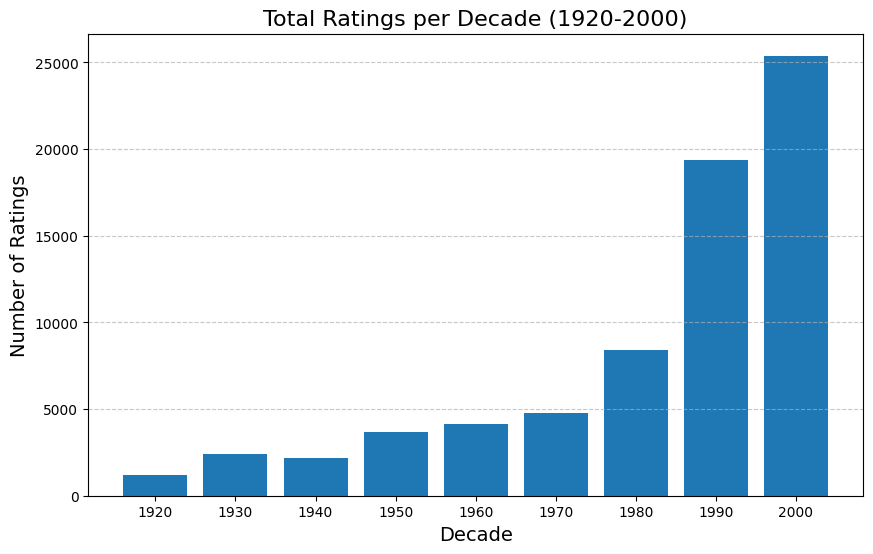

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load merged data
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Filter for 1920 to 2000
filtered_df = merged_df[(merged_df['decade'] >= 1920) & (merged_df['decade'] <= 2000)]

# Group by decade and count ratings
ratings_per_decade = filtered_df.groupby('decade')['rating'].count().reset_index()

# Plotting
plt.figure(figsize=(10,6))
plt.bar(ratings_per_decade['decade'], ratings_per_decade['rating'], width=8)

plt.title("Total Ratings per Decade (1920-2000)", fontsize=16)
plt.xlabel("Decade", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.xticks(ratings_per_decade['decade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import pandas as pd
import os
# Group by user_id and count number of ratings per user
ratings_per_user = merged_df.groupby('user_id')['rating'].count()

# Get min and max
min_ratings = ratings_per_user.min()
max_ratings = ratings_per_user.max()

print(f"Minimum number of ratings per user: {min_ratings}")
print(f"Maximum number of ratings per user: {max_ratings}")


Minimum number of ratings per user: 2
Maximum number of ratings per user: 200


In [32]:
import pandas as pd
import os

# Load merged data
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Count unique books per decade (including all decades, even strange ones)
books_per_decade = merged_df.groupby('decade')['book_id'].nunique().reset_index(name='unique_books')

# Sort by decade
books_per_decade = books_per_decade.sort_values('decade')

# Display full list of decades
print(books_per_decade.to_string(index=False))


 decade  unique_books
 -770.0             1
 -750.0             1
 -720.0             1
 -460.0             2
 -450.0             1
 -440.0             1
 -430.0             1
 -420.0             1
 -410.0             1
   -1.0             1
    0.0             1
 1300.0             1
 1390.0             2
 1590.0             1
 1600.0             4
 1710.0             1
 1720.0             2
 1800.0             1
 1810.0             4
 1840.0             9
 1850.0             4
 1860.0             6
 1870.0             3
 1880.0             7
 1890.0             7
 1900.0             9
 1910.0             9
 1920.0            12
 1930.0            25
 1940.0            22
 1950.0            37
 1960.0            42
 1970.0            49
 1980.0            86
 1990.0           197
 2000.0           260


In [33]:
unique_books = merged_df['book_id'].nunique()
print(f"Number of unique book IDs: {unique_books}")


Number of unique book IDs: 10000


In [35]:
import pandas as pd
import os

# Load merged data
data_path = '/Users/saramoshtaghi/Documents/Research/Recommender Systems/phd-svd-recsys/Book/data/goodbooks-10k'
merged_df = pd.read_csv(os.path.join(data_path, 'goodbooks.csv'))

# Group by decade, count unique books per decade
books_per_decade = merged_df.groupby('decade')['book_id'].nunique().reset_index(name='unique_books')

# Sort by decade
books_per_decade = books_per_decade.sort_values('decade')

# Show full output (all decades)
pd.set_option('display.max_rows', None)
print(books_per_decade)


    decade  unique_books
0   -770.0             1
1   -750.0             1
2   -720.0             1
3   -460.0             2
4   -450.0             1
5   -440.0             1
6   -430.0             1
7   -420.0             1
8   -410.0             1
9     -1.0             1
10     0.0             1
11  1300.0             1
12  1390.0             2
13  1590.0             1
14  1600.0             4
15  1710.0             1
16  1720.0             2
17  1800.0             1
18  1810.0             4
19  1840.0             9
20  1850.0             4
21  1860.0             6
22  1870.0             3
23  1880.0             7
24  1890.0             7
25  1900.0             9
26  1910.0             9
27  1920.0            12
28  1930.0            25
29  1940.0            22
30  1950.0            37
31  1960.0            42
32  1970.0            49
33  1980.0            86
34  1990.0           197
35  2000.0           260


In [36]:
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
missing_years = books['original_publication_year'].isnull().sum()
print(f"Books missing year: {missing_years}")


Books missing year: 21
